# Energy Production Forecasting

## 1. Business Understanding
### 1.1 Overview

Energy, as one of the key driving forces for economic growth, has always been considered by experts and scholars. Energy also plays a vital role in modern society, enabling systems that meet human needs such as sustenance, shelter, employment, and transportation. Thus, forecasting power demand plays an essential role in the electric industry, as it provides the basis for making decisions in power system planning and operation. In recent years, the US economy has enjoyed rapid development, and scholars have paid more attention to the energy demand and consumption in the country. In 2020, the U.S. spent $1 trillion on energy, or 4.8% of Gross Domestic Product (GDP). When spread over the population, annual costs were $3,039 per person. Environmental impacts associated with the production and consumption of energy include global climate change, acid rain, hazardous air pollution, smog, radioactive waste, and habitat destruction The nation’s heavy reliance on fossil fuels (primarily imported crude oil) poses major concerns for energy security. Potential gains in energy efficiency in all sectors may be offset by increases in consumption.

Prediction models have been developed for consumers of different size:  individual households, buildings, grids and plants.  Most prediction methods aim at determining the minimum and average levels of energy consumption and the economic costs involved. The ultimate goal is to raise awareness, apply corrections to actions already performed, and stimulate customers to increase efficiency, reduce energy consumption, or choose alternative (renewable) resources. Further, the mastering of future supply–demand development conditions will be good for the US government in adjusting the balance between supply and demand so as to enhance its economic development level and people’s living standards. Furthermore, it will be of reference significance for the energy policy-makers and market participants in other countries. This is especially important in countries looking to convert and adopt clean / renewable energy generation to reduce carbon footprint, meet regulatory standards or to simply refrain from investing capital in carbon capture technology. Because the sun does not shine all day and the wind does not blow, the forecasting of energy demand has become more relevant than ever to prevent shortages and blackouts.


### 1.2 Problem Statement

Accurate forecasts of electricity demand inform investment decisions about power generation and supporting network infrastructure. Inaccurate forecasts, whether they over or under predict demand, can have dire social and economic consequences. Underestimating demand results in supply shortages and forced power outages, with serious consequences for productivity and economic growth. Overestimating demand can lead to overinvestment in generation capacity, possible financial distress, and, ultimately, higher electricity prices.

### 1.3 Justification of the study

Projecting a society’s short-term and long-term electricity demand helps determine what capacity is needed for future energy generation. Forecasting power demand plays an essential role in the electric industry, as it provides the basis for making decisions in power system planning and operation. But electricity use arises from complex interactions between meteorological and socio-economic factors. Standard forecasting techniques are insufficient in such a dynamic environment, and more sophisticated methods are needed. Lastly, Optimization of energy consumption can also be achieved by adapting production to consumer 
demand.


### 1.4 Objective

General Objective

To predict future electricity production in the US to enhance its economic development level and people’s living standards.

Specific Objectives

1.	To build machine learning models that will predict the electricity production in the US.
2.	To find the best machine learning model with the most accurate prediction of electricity production.
3.	To give necessary recommendations to the client based on our model prediction.

Alternative Objectives 

To train a Machine Learning model being able to forecast (predict on future data) 30 periods ahead.

OR 

To offer more accurate models to predict electrical energy consumption in Slovakia than officially provided. 


### 1.5 Metric of Success

Build a machine learning model with the lowest Means Squared Error(MSE).




## 2. Data Understanding




In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from matplotlib import colors
from prophet import Prophet

In [2]:
#load the data into a dataframe and preview
df = pd.read_csv('data/electric_production.csv')
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


In [3]:
df.tail()

,DATE,IPG2211A2N
1001,2022-06-01,104.5230
1002,2022-07-01,115.5747
1003,2022-08-01,114.2425
1004,2022-09-01,100.5098
1005,2022-10-01,92.3498


In [4]:
#general description of the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1006 non-null   object 
 1   IPG2211A2N  1006 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


* The data type for date column is object and this should be changed to datetime format.
* The column name for IPG2211A2N column is not clear.

In [5]:
#checking the rows and colums
df.shape

(1006, 2)

The data has 1006 rows and 2 columns

In [6]:
#check for missing values
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values

In [7]:
#check for duplicates
df.duplicated().sum()

0

There are no dulpicates in our data

## 3. Data Preparation
#### 3.1 Validity

Here we renamed the columns first then changed the datatype of the date column to datetime format. Finally we picked the most relevant data for the project.

In [8]:
#change the column name
df.rename(columns={'IPG2211A2N':'energy_production(quads)', 'DATE':'date'}, inplace=True)

In [9]:
#change date column data type to datetime
df['date'] = pd.to_datetime(df['date'])

In [10]:
#setting the date as index
df.set_index('date', inplace=True)

Since the data spans for a very long period of time i.e 1939 to 2022, we decided to slice the data and work with more recent data

In [11]:
#slice the data from the year 1990
new_df = df['1990':]
#preview the new data
new_df.head()

,energy_production(quads)
date,
1990-01-01,83.3773
1990-02-01,76.2628
1990-03-01,72.3211
1990-04-01,66.4534
1990-05-01,65.0260


## 4. EDA and Visualization

### 4.1 Histogram and Density plot

We check the distribution of the time series data

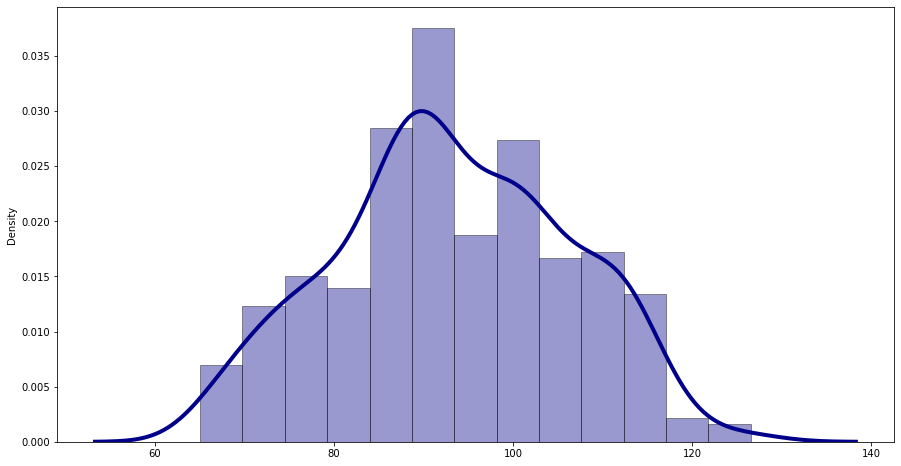

In [12]:
rcParams['figure.figsize'] = 15,8
sns.distplot(new_df, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}
             )
plt.xlabel('')
plt.show()

from the plot above the data is somewhat normally distributed


### 4.2 Time series line plot

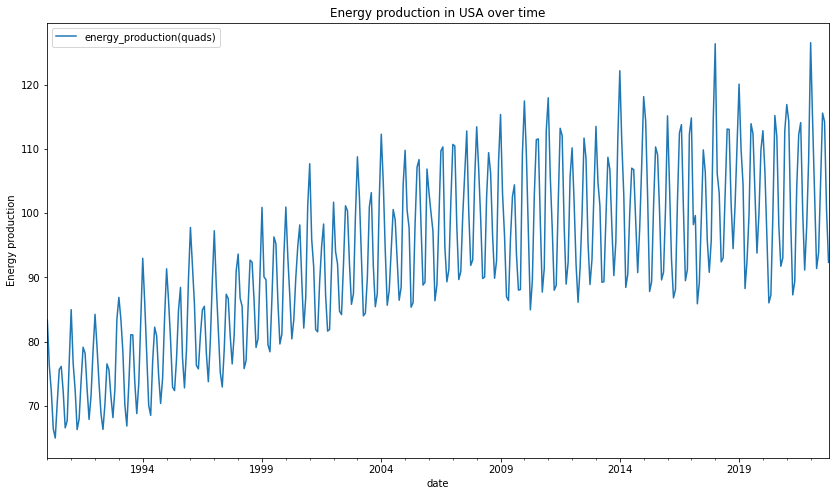

In [13]:
new_df.plot(figsize=(14,8))
plt.ylabel('Energy production')
plt.title('Energy production in USA over time')
plt.show()

We have observed a periodic and upward trend from 1990 to 2009 since the energy production increases over time and then after 2009 we have seasonal variation in our data.

### 4.3 Grouping and visualizing time series data

#### 4.3.1 Line Plots

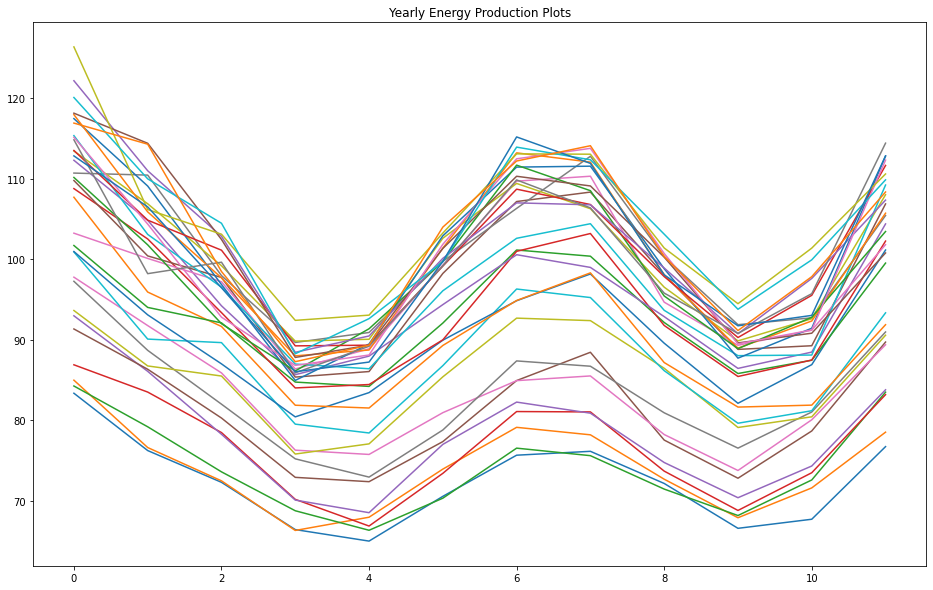

In [14]:
# Use pandas grouper to group values using annual frequency
year_groups = new_df['1990':'2021'].groupby(pd.Grouper(freq ='A'))
energy_annual = pd.DataFrame()
for yr, group in year_groups:
    energy_annual[yr.year] = group.values.ravel()


# Plot the yearly groups as subplots
energy_annual.plot(figsize = (16,10),subplots=False, legend=False)
plt.title('Yearly Energy Production Plots');

We can see in all plots above that due to the dense nature of time-series and a high correlation between the values in different years, we can not clearly identify any differences in these groups but we can spot seasonality within each year. 

#### 4.3.2 Box Plots and Whisker Plots

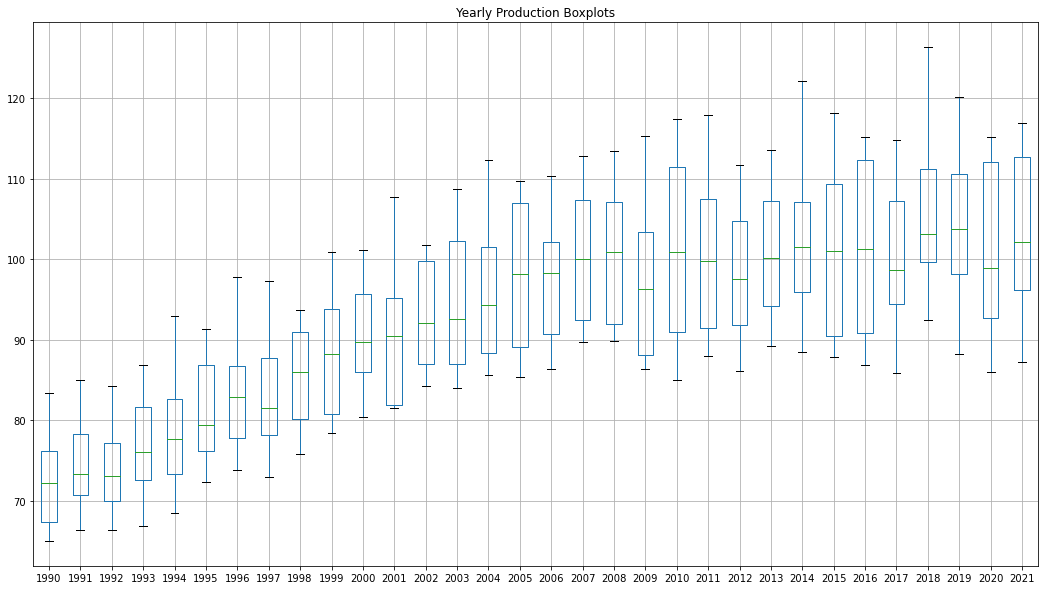

In [15]:
#we use groups by years to plot box and whisker plot for each year for direct comparison
energy_annual.boxplot(figsize = (18,10))
plt.title('Yearly Production Boxplots');

From the boxplot above, we can see that the time series data has no outliers.

### 4.4 Checking for Trends
We can see that that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. Let's reconfirm this here using both rolling statistics and the Dickey-Fuller test

#### 4.4.1 Rolling Statistics and The Dickey-Fuller Test

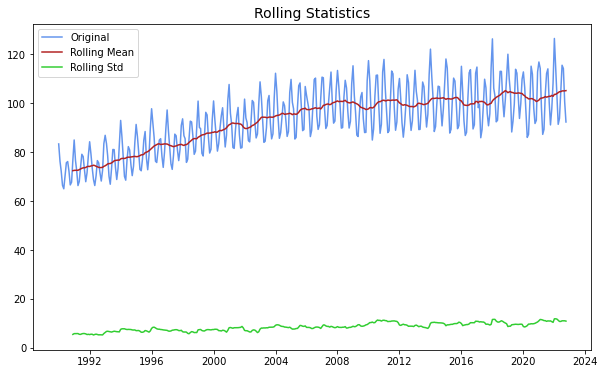

The Dickey-Fuller Test 

ADF Statistic: -2.041
p-value: 0.269
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [16]:
def stationarity_test(df, window = 12):
    
    roll_mean = df.rolling(window).mean()
    roll_std = df.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    original = plt.plot(df, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(roll_mean, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(roll_std, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 0)
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)

    print("The Dickey-Fuller Test \n")
    
    adf = adfuller(df, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("-------------------------------------------")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("-------------------------------------------")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
stationarity_test(new_df, window = 12)

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series.

The null-hypothesis for the test is that the time series is not stationary. The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

### 4.5 Removing trends

Time series models work on the assumption that the time series are stationary and in this case our time series is non-stationary. We need to remove the trends to convert our time series to stationary. We will employ the following methods:

* Log transformation
* Subtracting the rolling mean
* Decompositon

#### 4.5.1 Log transformation

One way to enforce stationarity can be a simple log transformation to make the time series more "uniform" over time.

The advantage of taking a log transformation is that higher values are penalized more than lower values.

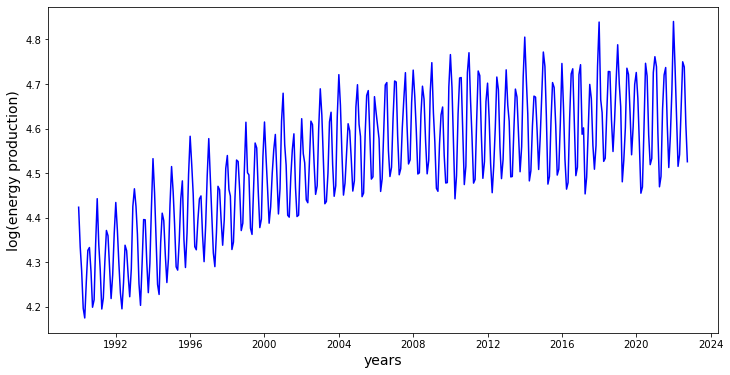

In [17]:
log_df = np.log(new_df['energy_production(quads)'])
fig = plt.figure(figsize=(12,6))
plt.plot(log_df, color='blue')
plt.xlabel('years', fontsize=14)
plt.ylabel('log(energy production)', fontsize=14)
plt.show()

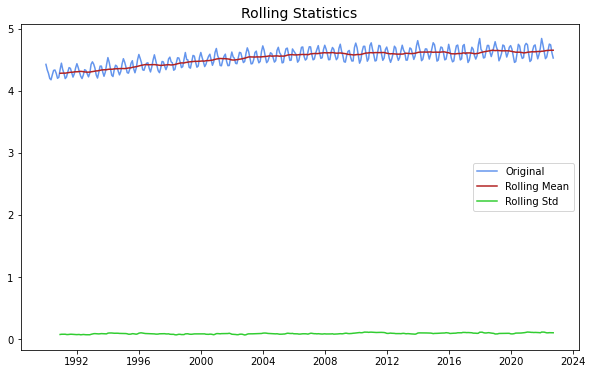

The Dickey-Fuller Test 

ADF Statistic: -2.416
p-value: 0.137
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [18]:
# Checking for ststionarity
stationarity_test(log_df, window = 12)

#### 4.5.2 Subtracting the rolling mean
Since the log transformed time series data above is non stationary, we will subtract the rolling mean from the log transformed time series data in an attempt to make it stationary. 

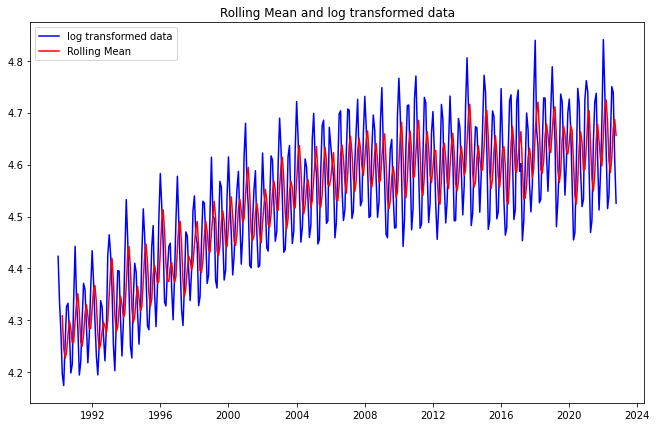

In [19]:
# calculating and visualizing rolling mean and log transformed data
roll_mean = log_df.rolling(window=4).mean()

fig = plt.figure(figsize=(11,7))
plt.plot(log_df, color='blue',label='log transformed data')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean and log transformed data')
plt.show(block=False)

In [20]:
# Subtracting rolling mean from log transformed data
logdf_minus_roll_mean = log_df - roll_mean
logdf_minus_roll_mean.head(10)

date
1990-01-01         NaN
1990-02-01         NaN
1990-03-01         NaN
1990-04-01   -0.112294
1990-05-01   -0.071860
1990-06-01    0.029465
1990-07-01    0.087945
1990-08-01    0.060174
1990-09-01   -0.019709
1990-10-01   -0.085526
Name: energy_production(quads), dtype: float64

In [21]:
# Drop the missing values from time series calculated above
logdf_minus_roll_mean.dropna(inplace=True)

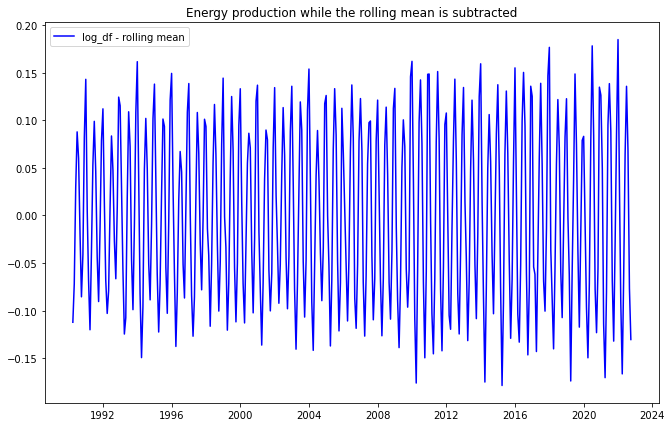

In [22]:
# Visualizing rolling mean subtracted from log transformed data
fig = plt.figure(figsize=(11,7))
plt.plot(logdf_minus_roll_mean, color='blue',label='log_df - rolling mean')
plt.legend(loc='best')
plt.title('Energy production while the rolling mean is subtracted')
plt.show(block=False)

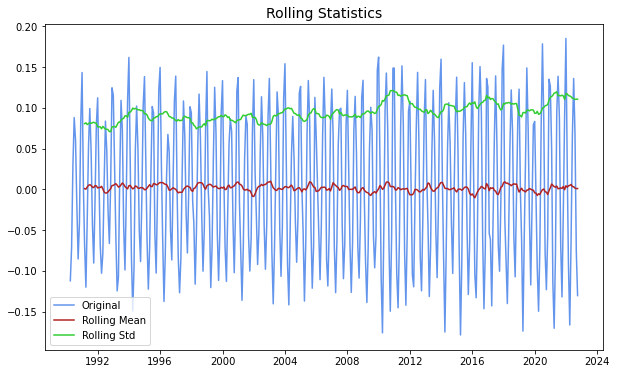

The Dickey-Fuller Test 

ADF Statistic: -7.237
p-value: 0.0
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [23]:
# Checking for stationarity
stationarity_test(logdf_minus_roll_mean, window = 12)

#### 4.5.3 Decompositon
Since our data is already stationary ,we decided to do decomposition in order to have a clear picture of trend,seasonal and residuals.

Time series decomposition is a mathematical procedure that transforms a time series into multiple different time series. The original time series is often split into three component series:
* Seasonal: Patterns that repeat within a fixed period.
* Trend: The underlying trend of the metrics.
* Random: Also called "noise", "irregular", or "remainder", this is the residual of the original time series after the seasonal and trend series are removed

To achieve successful decomposition, it is important to choose between the additive and multiplicative models, which requires analyzing the series.

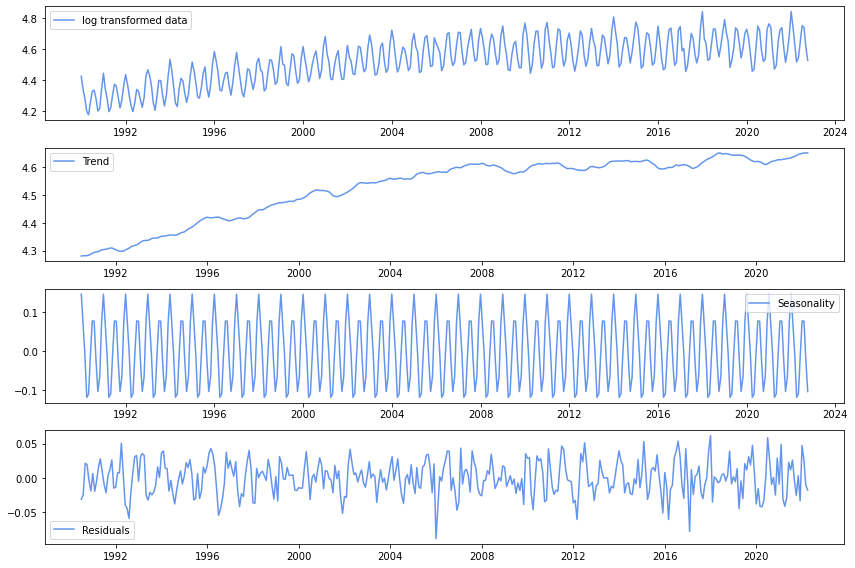

In [24]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_df)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(log_df, label='log transformed data', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='cornflowerblue')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend and seasonality are separated from data and we can model the residuals.
The plot above clearly shows the upward trend of our data, along with its yearly seasonality.

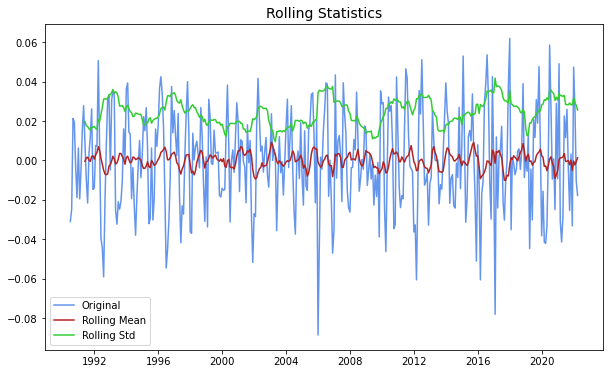

The Dickey-Fuller Test 

ADF Statistic: -9.692
p-value: 0.0
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [25]:
# Drop missing values from residuals
logdf_decompose = residual
logdf_decompose.dropna(inplace=True)
# Check stationarity
stationarity_test(logdf_decompose, window = 12)

The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. So it seems reasonable to assume this time series is stationary

### 4.6 Autocorrelation and  Partial Autocorrelation 
    
Autocorrelation analysis is an important step in the Exploratory Data Analysis of time series forecasting. The autocorrelation analysis helps detect patterns and check for randomness. It’s especially important when you intend to use an autoregressive–moving-average (ARMA) model for forecasting because it helps to determine its parameters. The analysis involves looking at the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

To determine the order of the model, you check the number of  lollipops above or below the confidence interval before the next lollipop enters the blue area

The ACF plot will provide answers to the following questions:

* Is the observed time series white noise/random?
* Is an observation related to an adjacent observation, an observation twice-removed, and so on?
* Can the observed time series be modeled with an MA model? If yes, what is the order?

The PACF plot will provide answers to the following question:

* Can the observed time series be modeled with an AR model? If yes, what is the order?

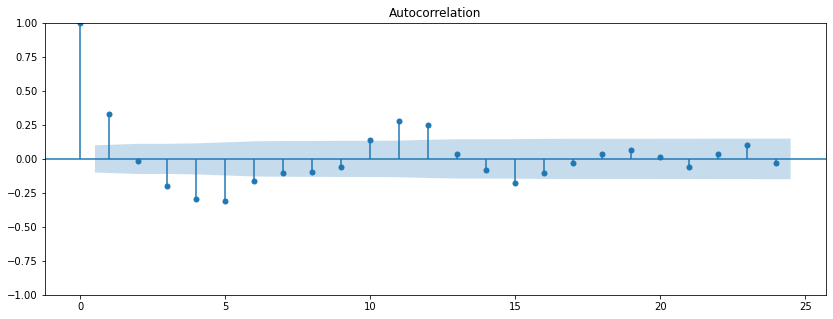

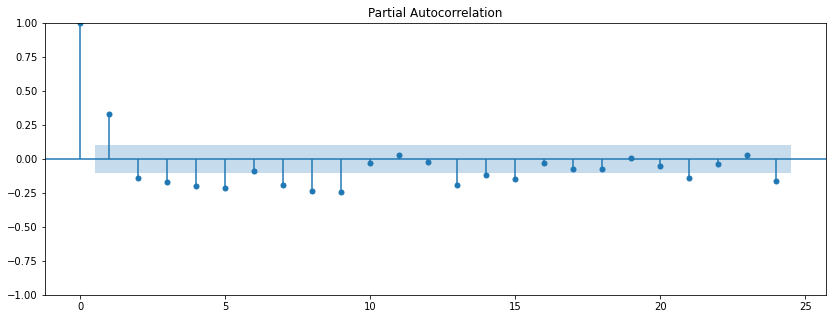

In [26]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(logdf_decompose, lags = 24)

plot_pacf(logdf_decompose, lags=24);

#### Auto Regressive(AR) observation 
* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

* High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 5) observations in PACF plot

* Geometric decay in ACF plot

#### Moving Average (MA)
* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

* High degree of autocorrelation between adjacent (lag = 1) in ACF plot

* Geometric decay in PACF plot


Based on the observations above, AR model will have an order of 5 and the MA model an order of 1.

### 5. Modelling
We are going to use the following models:
* Auto Regressive Model
* Moving Average Model
* ARIMA Model
* Facebook Prophet

We first split the data into training  and testing data

In [27]:
#splitting the data
split_values = logdf_decompose.values
train = split_values[1:len(split_values)-10] 
test = split_values[len(split_values)-10:]

#### 5.1 Auto regressive model
An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `5` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `0` in this case.

In [28]:
# instantiate AR model with an order of 5
ar_model = ARIMA(train, order=(5,0,0))

# fitting the model
ar_fitted = ar_model.fit()

# print out summary information of the fit
print(ar_fitted.summary())

print('\nEstimate for the constant and for theta:\n')

# Print out the estimate for the constant and for theta

print(ar_fitted.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  371
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 898.085
Date:                Wed, 30 Nov 2022   AIC                          -1782.169
Time:                        00:42:04   BIC                          -1754.756
Sample:                             0   HQIC                         -1771.282
                                - 371                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.646e-06      0.001     -0.009      0.993      -0.002       0.002
ar.L1          0.2874      0.049      5.875      0.000       0.192       0.383
ar.L2         -0.1129      0.046     -2.473      0.0

In [29]:
ar_predictions = ar_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, ar_predictions)
print('AR MSE: {}'.format(round(ar_score,6)))

AR MSE: 0.000656


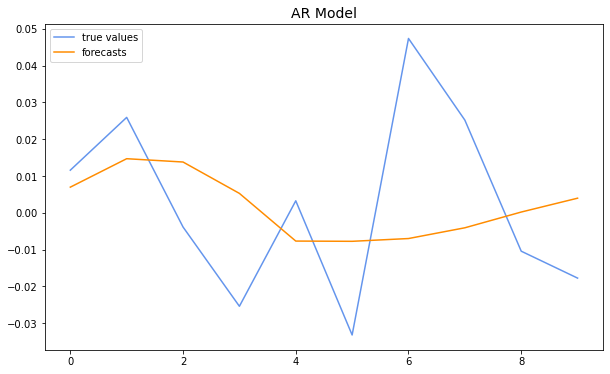

In [30]:
# visualizing the true values of the test and the predicted values
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(ar_predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

#### 5.2 Moving average model

The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `0` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `1` in this case.

In [31]:
# instantiate MA model with an order of 1
ma_model = ARIMA(train, order=(0,0,1))

# fitting the model
ma_fitted = ma_model.fit()

# print out summary information of the fit
print(ma_fitted.summary())

print('\nEstimate for the constant and for theta:\n')

# Print out the estimate for the constant and for theta

print(ma_fitted.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  371
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 873.668
Date:                Wed, 30 Nov 2022   AIC                          -1741.336
Time:                        00:42:04   BIC                          -1729.588
Sample:                             0   HQIC                         -1736.670
                                - 371                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.239e-05      0.002     -0.032      0.974      -0.003       0.003
ma.L1          0.3498      0.045      7.830      0.000       0.262       0.437
sigma2         0.0005   3.57e-05     14.765      0.0

In [32]:
ma_predictions = ma_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, ma_predictions)
print('MA MSE: {}'.format(round(ma_score,6)))

MA MSE: 0.000575


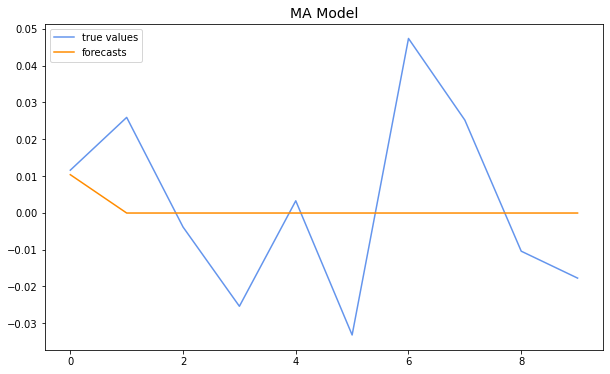

In [33]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(ma_predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

#### 5.3 ARIMA model
In this model, a regression on past values takes place (AR part) and also that the error term is modeled as a linear combination of error terms of the recent past (MA part)

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `5` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `1` in this case.

In [34]:
arima_model = ARIMA(train, order=(5,0,1))
arima_fitted = arima_model.fit()

arima_predictions = arima_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, arima_predictions)
print('ARIMA MSE: {}'.format(round(arima_score,6)))

ARIMA MSE: 0.000796


c:\Users\nguyo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


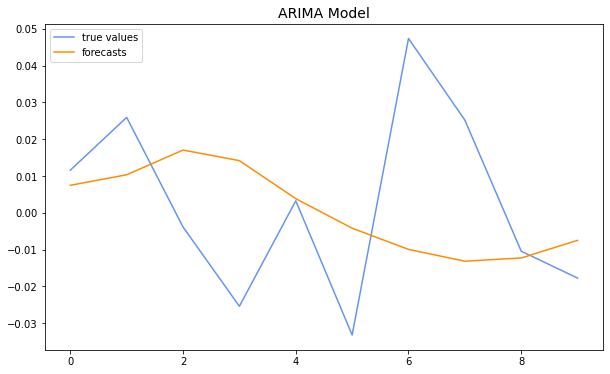

In [35]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(arima_predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

#### 5.4 Facebook Prophet Model

Facebook Prophet is an open-source algorithm for generating time-series models that uses a few old ideas with some new twists. It is particularly good at modeling time series that have multiple seasonalities and doesn’t face some of the above drawbacks of other algorithms.

Prophet requires as input a dataframe with two columns:

* ds: datetime column.
* y: numeric column which represents the measurement we wish to forecast.

In [36]:
# create timeseries readable by prophet
ts = new_df.copy()
ts.reset_index(inplace=True)
ts.rename(columns={'date':'ds', 'energy_production(quads)':'y'}, inplace=True)
ts['y'] = np.log(ts['y'])
ts

,ds,y
0,1990-01-01,4.423376
1,1990-02-01,4.334185
2,1990-03-01,4.281116
3,1990-04-01,4.196501
4,1990-05-01,4.174787
...,...,...
389,2022-06-01,4.649407
390,2022-07-01,4.749917
391,2022-08-01,4.738323
392,2022-09-01,4.610255


##### 5.4.1 Basic Facebook Prophet Model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Basic Prophet Model')

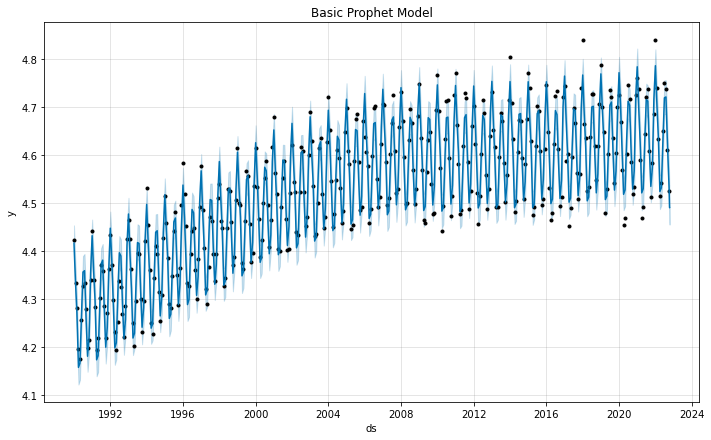

In [37]:
# instantiate the model and fit the timeseries
basic_prophet = Prophet()
basic_prophet.fit(ts)

# create a future data frame 
basic_future = basic_prophet.make_future_dataframe(periods=12)
basic_forecast = basic_prophet.predict(basic_future)

# display the most critical output columns from the forecast
basic_forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = basic_prophet.plot(basic_forecast)
plt.title('Basic Prophet Model')

In [38]:
#merge the predicted and the training values
df_merge = pd.merge(ts, basic_forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
basic_prophet_score = mean_squared_error(y_true, y_pred)
basic_prophet_score

0.000721750910709782

##### 5.4.2 Tuned Facebook Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Tuned Prophet Model')

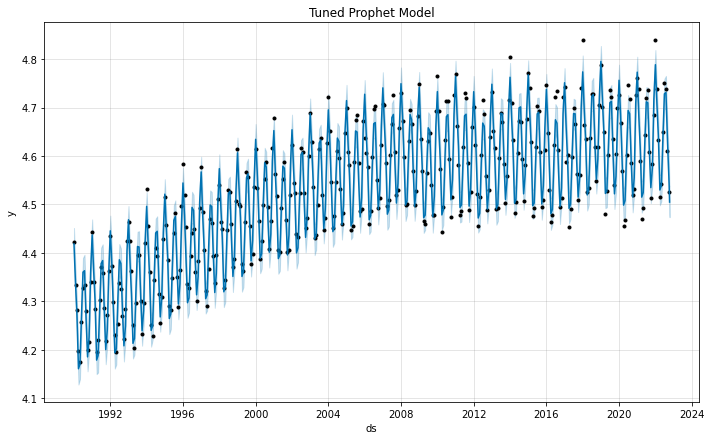

In [39]:
tuned_prophet = Prophet(weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75)
tuned_prophet.fit(ts)

# create a future data frame 
tuned_future = tuned_prophet.make_future_dataframe(periods=12)
tuned_forecast = tuned_prophet.predict(tuned_future)

# display the most critical output columns from the forecast
tuned_forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = tuned_prophet.plot(tuned_forecast)
plt.title('Tuned Prophet Model')

In [40]:
#merge the predicted and the training values
df_merge = pd.merge(ts, tuned_forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
tuned_prophet_score = mean_squared_error(y_true, y_pred)
tuned_prophet_score

0.0006048717935846033

In [41]:
errors = pd.DataFrame()
errors["Model"] = ["Autoregression", "Moving Average", "ARIMA", "Tuned Prophet", "Basic Prophet"]
errors["MSE"] = [ar_score, ma_score, arima_score, tuned_prophet_score, basic_prophet_score ]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
Moving Average,0.000575
Tuned Prophet,0.000605
Autoregression,0.000656
Basic Prophet,0.000722
ARIMA,0.000796


## 6. Conclusion

The implementation of a Time Series Analysis model to electricity production in US is presented. We were able to build Auto Regressive, Moving Average, ARIMA and Facebook Prophet models and actually forecast for a future time period. According to the MSE, the Moving Average model reported best socre in forecasting. 

### Another conclusion bit 

Electrical energy consumption forecasting is important for planning and facility expansion in the electric industry. Accurate forecasts can save operating and maintenance costs, increase the reliability of power supply and delivery systems, and correct decisions for future development. Forecasting is also important for the sustainable development of the electric power industry.

### Limitations

The analysis could be more meaningful if we could take other contributing factors such as energy consumption and production in different states, population...

### Next Steps
1.	To analyze also other statistical modelling techniques such as ARIMAX etc and neural networks to build your time series models.

2.	We can potentially add more recent data to increase the effectiveness of the model. 

3. Model Deployment
